In [1]:
import json
import re
import numpy as np
import tqdm as notebook_tqdm
import os
import spacy
from collections import defaultdict

In [ ]:
########################################################################
# NOTE: You must have Ego4D and Spacy downloaded locally for this notebook to work. This means you need an AWS profile set up in .aws.

# Run this block to do so once the AWS profile is present.
!ego4d --output_directory="~/ego4d" --datasets annotations
!python -m spacy download en_core_web_lg

########################################################################

### Step 0: Load Metadata ###

In [ ]:
# Read csv file line by line into a dict of line number:col values, skip header

verbs_lut = {}

#with open('C:\\Users\\saral\\physical-social-norms\\narration_verb_taxonomy.csv') as f:
with open('../narration_verb_taxonomy.csv') as f:
    lines = f.readlines()
    for cnt, line in enumerate(lines):
        line = line.strip()
        if "turn_off" in line:
            line = line.replace("turn_off", "turn off")
        if "turn_on" in line:
            line = line.replace("turn_on", "turn on")
        meaning = line.split("_")[0].split(',')[0].strip("\"")
        verbforms = line.split("[")[-1].split("]")[0].replace("'", "").split(", ")

        if cnt > 0:
            verbs_lut[meaning] = verbforms
 

In [ ]:
for key in verbs_lut.keys():
    print(key, verbs_lut[key])

In [ ]:
current_dir = os.getcwd()
metadata_dir = os.path.join(current_dir, 'ego4d', 'ego4d.json')
data_dir = os.path.join(current_dir, 'ego4d', 'v2', 'annotations', 'all_narrations_redacted.json')


metadata = json.load(open(metadata_dir))

metadata = metadata['videos']

videos_metadata = {}

for video in metadata:
    # print(video)
    videos_metadata[video["video_uid"]] = {}
    videos_metadata[video["video_uid"]]["scenarios"] = video["scenarios"]
    videos_metadata[video["video_uid"]]["has_audio"] = video["video_metadata"]["audio_start_sec"] != None
    videos_metadata[video["video_uid"]]["is_stereo"] = video["is_stereo"]
    videos_metadata[video["video_uid"]]["split_fho"] = video["split_fho"]
    videos_metadata[video["video_uid"]]["has_redacted_regions"] = video["has_redacted_regions"]

In [5]:
videos_metadata[video["video_uid"]]

{'scenarios': ['Carpenter',
  'Fixing something in the home',
  'Talking with family members'],
 'has_audio': True,
 'is_stereo': False,
 'split_fho': None,
 'has_redacted_regions': False}

### Step 1: Load Narrations and Filter ###

In [6]:
data = json.load(open(data_dir))

In [7]:
# Count number of narrations
narration_count = 0
for vid_id in data['videos'].keys():
    narrations = data['videos'][vid_id]['narrations']
    narration_count += len(narrations)

print(f"Total number of narrations: {narration_count}")

Total number of narrations: 6996126


In [8]:
# Filtering rules
exclude = ['camera', '#unsure']

# Widened scope of verbs beyond original physical_interactions (['give', 'collect', 'pass', 'hand', 'show', 'pick'])
                         
videos = {}
keys = data['videos'].keys()
tqdadm = notebook_tqdm.tqdm(keys)
for key in tqdadm:
    video = key
    valid_narrations = []
    is_stereo = videos_metadata[video]['is_stereo']
    has_redacted_regions = videos_metadata[video]['has_redacted_regions']
    for narration in data['videos'][video]['narrations']:
        txt = narration['text']
        # txt should contain two capital letters with spaces (to force selection of multi-person interactions)
        if re.search(r'\#C C .* ([B-Z] .*| [B-Z])', txt) or re.search(r'\#C [B-Z] .* (C .*| C)', txt):

            # Exclude narrations based on above rules
            if exclude[0] not in txt and exclude[1] not in txt and not has_redacted_regions and not is_stereo:

                # If narration has #C twice, then reject
                if txt.count("#C") > 1:
                    continue

                valid_narrations.append((narration['time'], narration['text'], narration['_annotation_uid']))
    if len(valid_narrations) > 0:
        videos[video] = valid_narrations

  0%|          | 0/8922 [00:00<?, ?it/s]

100%|██████████| 8922/8922 [00:12<00:00, 691.18it/s] 


In [9]:
# Count number of narrations after filtering
narration_count = 0
for vid_id in videos.keys():
    narration_count += len(videos[vid_id])

print(f"Total number of filtered narrations: {narration_count}")

Total number of filtered narrations: 46431


In [ ]:
# Load samples.json and final_filtered_samples.json, parse to dicts, diff the two to get the samples to exclude

if os.path.exists('./samples/samples.json'):
    samples = json.load(open('./samples/samples.json'))['samples']
else:
    samples = []

prev_seen_videos = set()

s1 = []

for i in range(len(samples)):
    i = samples[i]
    video_id = i['video_id']
    _time = i["action_time"]
    time_stamp = format(float(_time), ".2f").replace('.', '-')
    id = f'{video_id}_{time_stamp}'

    prev_seen_videos.add(video_id)


Number of samples to exclude: 549
Previous number of samples: 3011


### Step 2: Extract Lemma for Each Narration Word; Map Verbs:Lemma in LUT ###

In [10]:
# Function to cluster by verb
# Find verb in each narration, map to verb list, assign to cluster 
def cluster_by_verb(sentences):
    # Extract verbs from each narration
    nlp = spacy.load("en_core_web_lg")

    # Extract all narrations across all videos
    all_narrations = []
    for video in sentences.keys():
        for time, txt, _ in sentences[video]:
            all_narrations.append(txt[3:].strip())

    # Process all narrations in batches
    token_text = []
    token_pos = []
    for doc in notebook_tqdm.tqdm(nlp.pipe(all_narrations, batch_size=32), total=len(all_narrations), desc="Processing sentences"):
        # Extract verbs
        token_text.append([token.lemma_ for token in doc])
        token_pos.append([token.pos_ for token in doc])

    starting_idx = 0

    # Rebuild sentences with token text and pos, can iterate in order
    for video in sentences.keys():

        # Add to sentences by rebuilding tuples
        for i, sentence in enumerate(sentences[video]):
            sentences[video][i] = (sentence[0], sentence[1], sentence[2], token_text[starting_idx+i], token_pos[starting_idx+i])

        starting_idx += len(sentences[video])

    return sentences

In [11]:
# Garbage collect data if variable exists
#if 'data' in locals():
#    del data

vs = cluster_by_verb(videos)

Processing sentences: 100%|██████████| 46431/46431 [01:09<00:00, 670.15it/s] 


In [12]:
# Count number of narrations after lemma extraction (should be same as before)
narration_count = 0
for vid_id in vs.keys():
    narration_count += len(vs[vid_id])

print(f"Total number of filtered narrations: {narration_count}")

Total number of filtered narrations: 46431


In [13]:
# Iterate over all videos and narrations to build verb clusters 
video_clustered = {}

nf = 0

# Iterate over all videos using tqdm
for clip in notebook_tqdm.tqdm(vs.keys(), desc="Processing videos"):
    # Iterate over all narrations
    updated_narrations = []

    # Iterate over every inbound narration per video
    for time, txt, uid, lemmas, pos in vs[clip]:
        # print all lemma and match to verb_lut (can do this with POS tagging but less reliable)
        notfound = True
        for word in lemmas:
            # Cast word to lowercase
            word = word.lower()
            if len(word) > 2 and notfound:
                for meaning, verbforms in verbs_lut.items():
                    if word in verbforms and notfound: # Need conditional here to avoid double assignment in case multiple matches
                        updated_narrations.append((time, txt, uid, lemmas, pos, meaning))
                        notfound = False
        
        if notfound:
            nf += 1
            
            meaning = "unknown"
        # Reconstruct tuple with verb meaning
            updated_narrations.append((time, txt, uid, lemmas, pos, meaning))

    video_clustered[clip] = updated_narrations

Processing videos: 100%|██████████| 2736/2736 [00:01<00:00, 1791.74it/s]


In [14]:
# Count number of narrations after mapping to verb clusters (should be same as before)
narration_count = 0
for vid_id in video_clustered.keys():
    narration_count += len(video_clustered[vid_id])

print(f"Total number of filtered narrations: {narration_count}")

Total number of filtered narrations: 46431


### Step 3: Parse Scenarios ###

In [15]:
available_scenarios = set()

# Iterate over keys of video_clustered, find corresponding scenarios in metadata
for clip in video_clustered.keys():
    for scenario in videos_metadata[clip]['scenarios']:
        available_scenarios.add(scenario)

In [16]:
list(video_clustered.values())[0]

[(270.25537053333335,
  '#C C and Y shapes dough pieces.',
  '566c02ec-f206-4f45-a4f6-cdb807dc4d62',
  ['C', 'and', 'Y', 'shape', 'dough', 'piece', '.'],
  ['PROPN', 'CCONJ', 'PROPN', 'VERB', 'VERB', 'NOUN', 'PUNCT'],
  'mold'),
 (810.1946953125,
  '#C C interacts with a woman X and a woman Y.',
  '559df93a-d4b7-4e89-80e8-9141a0104b22',
  ['C', 'interact', 'with', 'a', 'woman', 'x', 'and', 'a', 'woman', 'Y.'],
  ['PROPN',
   'VERB',
   'ADP',
   'DET',
   'NOUN',
   'NOUN',
   'CCONJ',
   'DET',
   'NOUN',
   'PROPN'],
  'talk'),
 (811.6757653125001,
  '#C C dialogues with person H ',
  'f1955fab-8c9d-4514-9dd3-4e4d6ddd30c3',
  ['c', 'dialogue', 'with', 'person', 'H'],
  ['NOUN', 'NOUN', 'ADP', 'NOUN', 'PROPN'],
  'talk'),
 (816.5075653125,
  '#C C dialogues with person H ',
  'f1955fab-8c9d-4514-9dd3-4e4d6ddd30c3',
  ['c', 'dialogue', 'with', 'person', 'H'],
  ['NOUN', 'NOUN', 'ADP', 'NOUN', 'PROPN'],
  'talk'),
 (831.2975253125,
  '#C C talks to person X ',
  '5f3505f2-4929-4147-9018

### Step 4: Select Samples Based on Uniqueness Heuristic ###

In [17]:
# Process for sample selection:
# 1. Cluster snippets by verb
# 2. For each cluster, randomly sample the snippets belonging to each unique scenario

verb_clusters = {}
# Fill with verb lemmas as keys

for verb_lemma in list(verbs_lut.keys())+['unknown']:
    verb_clusters[verb_lemma] = []
    # For each video
    for vid, info in video_clustered.items():
        # For each narration in the video
        for narration in info:
            # Construct datapoint
            datapoint = [vid, narration[0], narration[1], narration[2], narration[5]]

            if narration[5].lower().strip() == verb_lemma:
                verb_clusters[verb_lemma].append(datapoint)

In [57]:
# Count and print number of snippets per verb cluster
for verb_lemma in verb_clusters.keys():
    print(f"Number of snippets in cluster {verb_lemma}: {len(verb_clusters[verb_lemma])}")

print(f"Total number of snippets: {sum([len(verb_clusters[verb_lemma]) for verb_lemma in verb_clusters.keys()])}")

Number of snippets in cluster adjust: 291
Number of snippets in cluster apply: 361
Number of snippets in cluster arrange: 452
Number of snippets in cluster attach: 61
Number of snippets in cluster blow: 259
Number of snippets in cluster break: 23
Number of snippets in cluster carry: 104
Number of snippets in cluster catch: 37
Number of snippets in cluster clap: 21
Number of snippets in cluster clean: 269
Number of snippets in cluster climb: 36
Number of snippets in cluster close: 23
Number of snippets in cluster consume: 43
Number of snippets in cluster count: 4
Number of snippets in cluster cover: 17
Number of snippets in cluster crochet: 0
Number of snippets in cluster cross: 76
Number of snippets in cluster cut: 114
Number of snippets in cluster detach: 8
Number of snippets in cluster dig: 1
Number of snippets in cluster dip: 1
Number of snippets in cluster divide: 31
Number of snippets in cluster draw: 129
Number of snippets in cluster drill: 2
Number of snippets in cluster drive: 

In [ ]:
# For each verb cluster, randomize order of snippets

# Banned scenarios
banned_scenarios = ['Playing cards', 'Playing board games', 'DEPRECATED : Playing board games', 'Assembling a puzzle', 'Hair and Makeup stylist',
                    'Going to a salon (nail, hair, spa)', 'Scooter mechanic', 'Bike mechanic', 'Pulp Traces Factory (Egges)']

inbound_verbs = ['give', 'hit', 'strike', 'take', 'unknown']

chosen_samples = []

sampled_scenarios_per_lemma = {}

n = 1 # Choose max of 1 sample per verb-activity combo

video_prev_sampled = {}

for verb_lemma in verb_clusters.keys():
    # Randomize order of snippets
    # Sample n snippets per scenario, per verb cluster

    sampled_scenarios_per_lemma[verb_lemma] = {}

    for snippet in verb_clusters[verb_lemma]:
        # Get scenarios corresponding to vid from metadata
        scenarios = videos_metadata[snippet[0]]['scenarios']

        # Check that scenario is not empty
        if len(scenarios) == 0:
            continue

        video_uid = snippet[0]

        video_id = snippet[0]
        _time = snippet[1]
        time_stamp = format(float(_time), ".2f").replace('.', '-')
        id = f'{video_id}_{time_stamp}'

        oversampled_scenario = False

        # Check that scenario is not banned
        for b in banned_scenarios:
            if b in scenarios:
                oversampled_scenario = True

        if video_uid in video_prev_sampled:
            if video_prev_sampled[video_uid] >= n:
                oversampled_scenario = True
            else:
                video_prev_sampled[video_uid] += 1
        else:
            video_prev_sampled[video_uid] = 1

        if verb_lemma not in inbound_verbs:
            oversampled_scenario = True

        if not oversampled_scenario:
            chosen_samples.append(snippet)

In [ ]:
# Count number of verbs

verb_to_count = {}

for i in chosen_samples:
    verb_lemma = i[4]
    if verb_lemma in verb_to_count:
        verb_to_count[verb_lemma] += 1
    else:
        verb_to_count[verb_lemma] = 1

for vl in verb_to_count.keys():
    print(f"Number of snippets in cluster {vl}: {verb_to_count[vl]}")


Number of snippets in cluster adjust: 3
Number of snippets in cluster cross: 9
Number of snippets in cluster drive: 1
Number of snippets in cluster hold: 14
Number of snippets in cluster move: 45
Number of snippets in cluster play: 8
Number of snippets in cluster point: 4
Number of snippets in cluster put: 18
Number of snippets in cluster take: 108
Number of snippets in cluster throw: 1
Number of snippets in cluster touch: 16
Number of snippets in cluster turn: 10
Number of snippets in cluster walk: 85
Number of snippets in cluster watch: 41
Number of snippets in cluster wipe: 1
Number of snippets in cluster show: 3
Number of snippets in cluster unknown: 12


In [91]:
def get_summary(video_id, time):
    for summary in data['videos'][video_id]['summaries']:
        if summary['start_time'] <= time <= summary['end_time']:
            return summary['text']
    return None

def get_previous_snippet(video_id, time):
    for i, snippet in enumerate(data['videos'][video_id]['narrations']):
        if snippet['time'] == time:
            if i == 0:
                return data['videos'][video_id]['narrations'][0]
            else:
                return data['videos'][video_id]['narrations'][i-1]
            
def get_next_snippet(video_id, time):
    for i, snippet in enumerate(data['videos'][video_id]['narrations']):
        if snippet['time'] == time:
            if i == len(data['videos'][video_id]['narrations'])-1:
                return data['videos'][video_id]['narrations'][-1]
            else:
                return data['videos'][video_id]['narrations'][i+1]

### Step 5: Save to samples.json ###

In [ ]:
samples = []

for sample in chosen_samples:
    video_id = sample[0]
    ac_time = sample[1]
    txt = sample[2]
    summary = get_summary(video_id, ac_time)
    verb = sample[-1]

    prev_narration = get_previous_snippet(video_id, ac_time)
    next_narration = get_next_snippet(video_id, ac_time)

    prev_time = prev_narration['time']
    prev_id = prev_narration['_annotation_uid']
    
    samples.append({
        'video_id': video_id,
        'prev_time': prev_time,
        'prev_id': prev_id,
        'action_time': ac_time,
        'next_time': next_narration['time'],
        'txt': txt,
        'summary': summary,
        'scenarios': videos_metadata[video_id]['scenarios'],
        'verb': verb,
        'Behaviors': ['', '', '', '', ''],
        'Justifications': ['', '', '', '', ''],
        'taxonomy': {'0': '', '1': '', '2': '', '3': '', '4': ''},
    })

# Randomize order of samples before saving

samples = {
    'samples': samples
}

with open('./samples/samples.json', 'w') as f:
    json.dump(samples, f, indent=4)

# Also save in final_data form
final_data = {}
final_data_eval = {}
for sample in chosen_samples:
    video_id = sample[0]
    ac_time = sample[1]
    txt = sample[2]
    summary = get_summary(video_id, ac_time)
    verb = sample[-1]

    prev_narration = get_previous_snippet(video_id, ac_time)
    next_narration = get_next_snippet(video_id, ac_time)

    prev_time = prev_narration['time']
    prev_id = prev_narration['_annotation_uid']

    final_data[video_id] = {
        'id': video_id,
        'behaviors': ['', '', '', '', ''],
        'justifications': ['', '', '', '', ''],
        'correct': None,
        'sensibles': [],
        'taxonomy': {0: '', 1: '', 2: '', 3: '', 4: ''},
        'desc': ''
    }
    final_data_eval[video_id] = {}

with open('../final_data/generated_data.json', 'w') as f:
    json.dump(final_data, f, indent=4)

with open('../final_data/generated_data_eval.json', 'w') as f:
    json.dump(final_data_eval, f, indent=4)

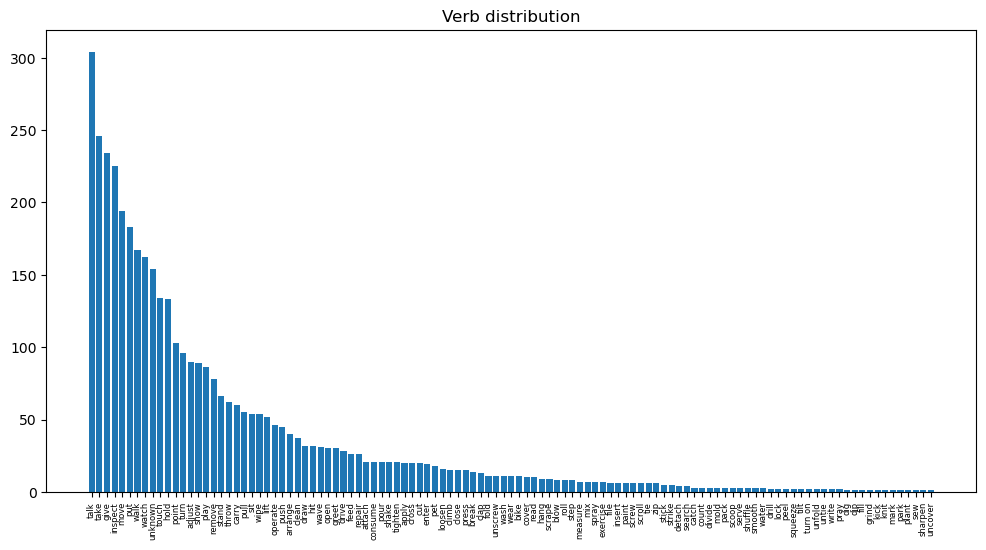

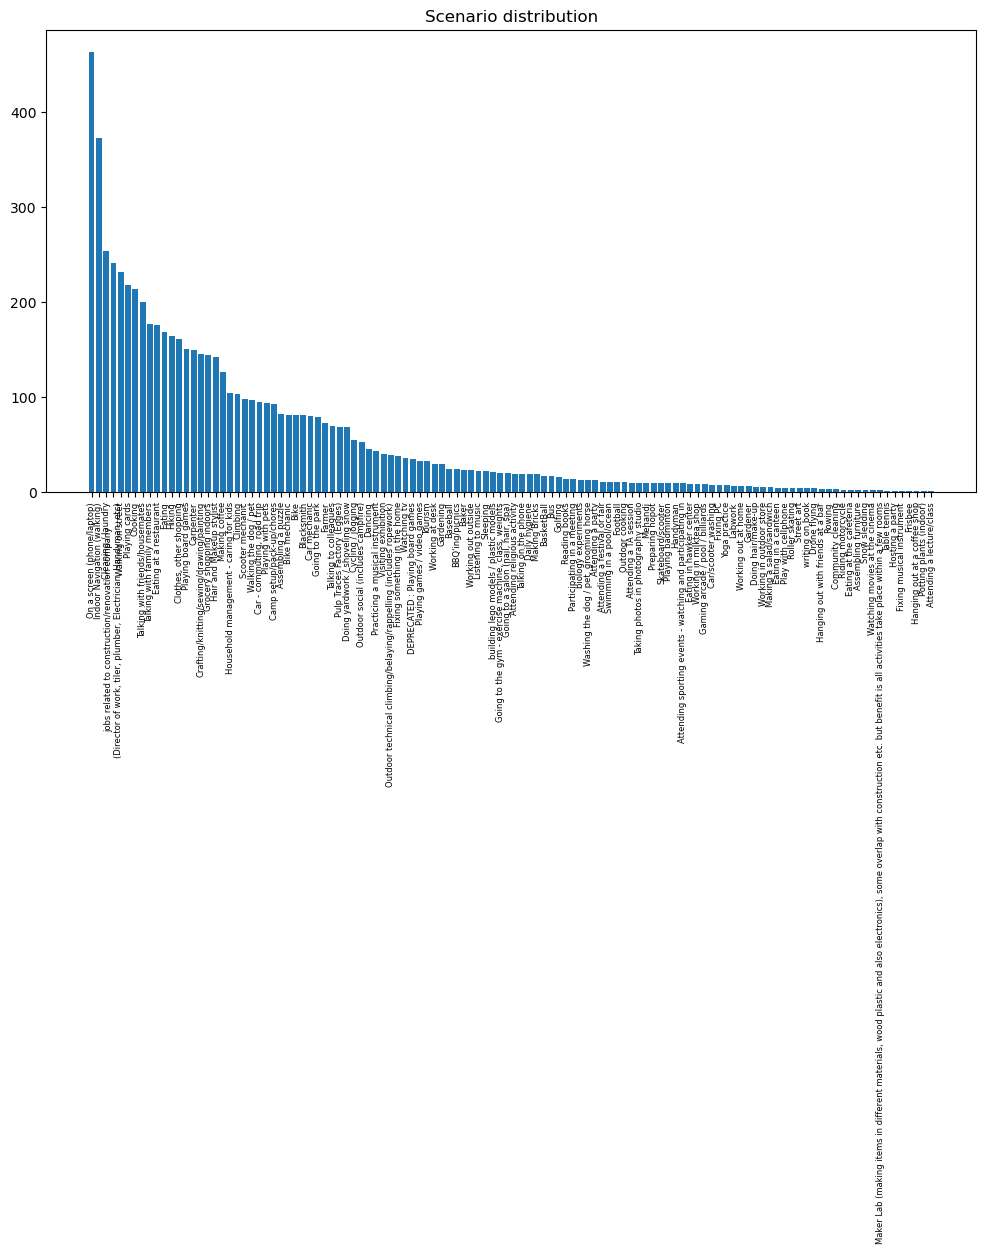

In [140]:
import matplotlib.pyplot as plt

# Load samples.json and compile stats
samples = json.load(open('samples.json'))

# Create histograms of verb distribution and scenario distribution
verb_counts = defaultdict(int)
scenario_counts = defaultdict(int)

combo_counts = defaultdict(int)

for sample in samples['samples']:
    verb_counts[sample['verb']] += 1
    for scenario in sample['scenarios']:
        scenario_counts[scenario] += 1
# Sort defaultdicts by value
verb_counts = dict(sorted(verb_counts.items(), key=lambda item: item[1], reverse=True))
scenario_counts = dict(sorted(scenario_counts.items(), key=lambda item: item[1], reverse=True))

# Plot verb distribution, small text size for x-axis
plt.figure(figsize=(12, 6))
plt.bar(verb_counts.keys(), verb_counts.values())
plt.xticks(rotation=90, fontsize=6)
plt.title("Verb distribution")
plt.show()

# Plot scenario distribution
plt.figure(figsize=(12, 6))
plt.bar(scenario_counts.keys(), scenario_counts.values())
plt.xticks(rotation=90, fontsize=6)
plt.title("Scenario distribution")
plt.show()